# Introducció

En aquest treball analitzarem un dataset del rendiment d'una GPU (tarjeta gràfica) fent una operació de multiplicació amb matrius 2048 * 2048, fent us d'un kernel parametritzable amb 241600 possibles combinacions de paràmetres. En aquest dataset, tenim 4 execucions de les operacions per cada combinació de paràmetres.

https://www.kaggle.com/datasets/rupals/gpu-runtime

https://archive.ics.uci.edu/ml/datasets/SGEMM+GPU+kernel+performance

L'experiment va estar executat en un ordinador d'escriptori, amb les seguents especificacions:

* Ubuntu 16.04
* Intel Core i5 (3.5GHz)
* 16GB RAM
* NVidia GeForce GTX 680 4GB GF580 GTX-1.5GB GPU


# Llibreries utilitzades

Les llibreries que utilitzarem per la realització dels analisis son:

* Pandas: llibreria que utilitzarem per generar les estructures de dades en forma de taula a partir de la base de dades (CSV)
* Numpy: llibreria que ens servirà pe realitzar operacions molt eficients amb grans estructures de dades, com matrius o arrays
* Matplotlib: llibreria per visualitzar els resultats en forma de gràfiques
* Scipy: llibreria que incorpora moltes funcions matematiques
* Seaborn: similar a matplotlib i genera grafiques més complexes
* Sklearn: incorpora tots els models d'aprenentatge computacional que utilitzarem per predir, i funcions d'anàlisi

In [62]:
from warnings import filterwarnings
filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
import scipy.stats
import math
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Perceptron, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.model_selection import cross_val_score

# Exploratory Data Analysis

En aquest apartat visualitzarem les característiques del nostre dataset i farem les transformacions necessàries.

In [3]:
dataset = pd.read_csv("BBDD/sgemm_product.csv")
dataset.head()

,MWG,NWG,KWG,MDIMC,NDIMC,MDIMA,NDIMB,KWI,VWM,VWN,STRM,STRN,SA,SB,Run1 (ms),Run2 (ms),Run3 (ms),Run4 (ms)
0,16,16,16,8,8,8,8,2,1,1,0,0,0,0,115.26,115.87,118.55,115.80
1,16,16,16,8,8,8,8,2,1,1,0,0,0,1,78.13,78.25,79.25,79.19
2,16,16,16,8,8,8,8,2,1,1,0,0,1,0,79.84,80.69,80.76,80.97
3,16,16,16,8,8,8,8,2,1,1,0,0,1,1,84.32,89.90,86.75,85.58
4,16,16,16,8,8,8,8,2,1,1,0,1,0,0,115.13,121.98,122.73,114.81


Com podem observar, les primeres 14 columnes son els atributs parametritzables que utilitzarà el kernel, i les ultimes 4 columnes (Run1, Run2, ... Run4) son les execucions de les operacions en milisegons.

Descripció breu dels atributs:
* **MWG and NWG**: per-matrix 2D tiling at workgroup level: {16, 32, 64, 128} (integer)
* **KWG**: inner dimension of 2D tiling at workgroup level: {16, 32} (integer)
* **MDIMC and NDIMC**: local workgroup size: {8, 16, 32} (integer)
* **MDIMA and NDIMB**: local memory shape: {8, 16, 32} (integer)
* **KWI**: kernel loop unrolling factor: {2, 8} (integer)
* **VWM and VWN**: per-matrix vector widths for loading and storing: {1, 2, 4, 8} (integer)
* **STRM and STRN**: enable stride for accessing off-chip memory within a single thread: {0, 1} (categorical)
* **SA and SB**: per-matrix manual caching of the 2D workgroup tile: {0, 1} (categorical)

Mostrem el tamany del dataset:

In [4]:
dataset.shape

(241600, 18)

Comprovem que no hi hagin valors no existents (NaN):

In [5]:
dataset.isnull().sum()

MWG          0
NWG          0
KWG          0
MDIMC        0
NDIMC        0
MDIMA        0
NDIMB        0
KWI          0
VWM          0
VWN          0
STRM         0
STRN         0
SA           0
SB           0
Run1 (ms)    0
Run2 (ms)    0
Run3 (ms)    0
Run4 (ms)    0
dtype: int64

No en tenim valors NaN per tant no cal fer cap processament d'aquests.


# Data preprocessing

Com podem veure la variable target està dividida en 4 execucions independents. Les agruparem en una sola per simplificar el dataset:

In [6]:
dataset['Run (ms)']=dataset[['Run1 (ms)','Run2 (ms)','Run3 (ms)','Run4 (ms)']].mean(axis=1)
dataset = dataset.drop(columns =['Run1 (ms)','Run2 (ms)','Run3 (ms)','Run4 (ms)'], axis = 1)
dataset.head()

,MWG,NWG,KWG,MDIMC,NDIMC,MDIMA,NDIMB,KWI,VWM,VWN,STRM,STRN,SA,SB,Run (ms)
0,16,16,16,8,8,8,8,2,1,1,0,0,0,0,116.3700
1,16,16,16,8,8,8,8,2,1,1,0,0,0,1,78.7050
2,16,16,16,8,8,8,8,2,1,1,0,0,1,0,80.5650
3,16,16,16,8,8,8,8,2,1,1,0,0,1,1,86.6375
4,16,16,16,8,8,8,8,2,1,1,0,1,0,0,118.6625


Ara ja tenim el dataset dividit en X (atributs independents) i Y (atribut target)


Mostrem la distribució de valors el atribut target:

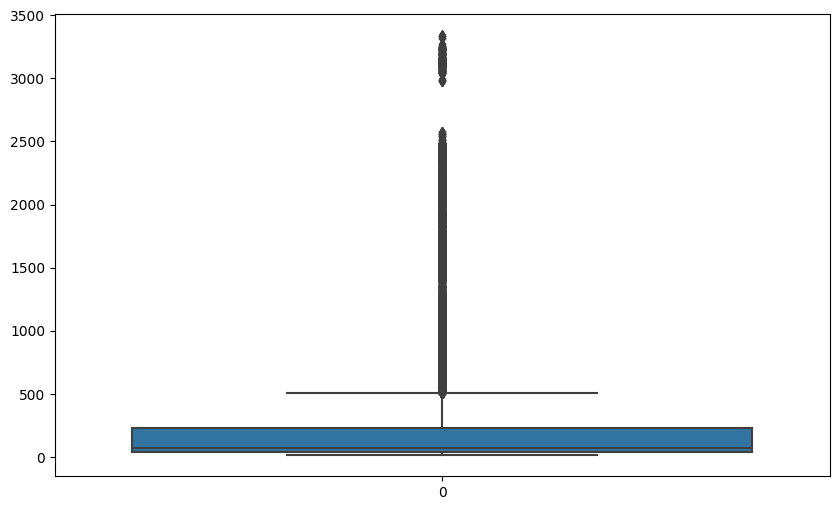

In [7]:
plt.figure(figsize=(10,6))
sns.boxplot(dataset['Run (ms)']);



Com podem veure hi ha molts outliers (gran dispersió de valors), per la qual cosa fem un outlier removal:

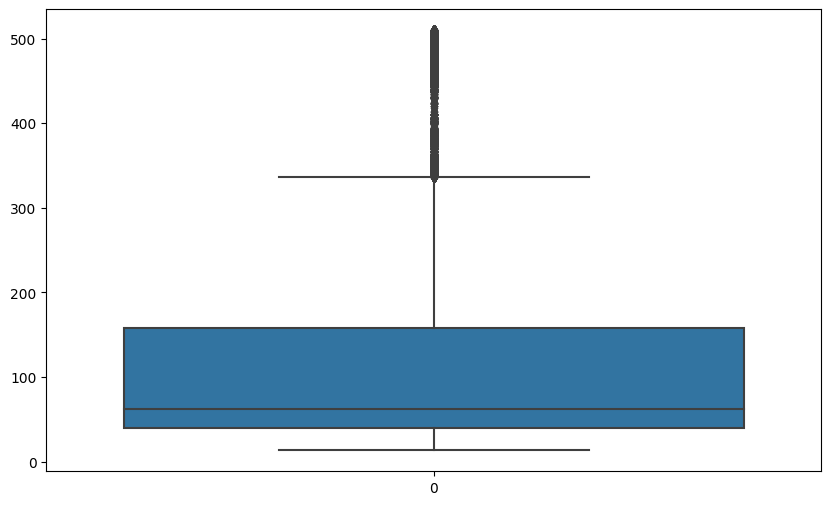

In [8]:
Q1=dataset['Run (ms)'].quantile(0.25)
Q2=dataset['Run (ms)'].quantile(0.75)
IQR = Q2 - Q1
LL=Q1-1.5*IQR
UL=Q2+1.5*IQR
dataset2 = dataset[(dataset['Run (ms)']>LL) & (dataset['Run (ms)']<UL)]
dataset2.describe()

plt.figure(figsize=(10,6))
sns.boxplot(dataset2['Run (ms)']);

Ara ja tenim una dispersió de valors molt més concentrada 

A continuació veurem la correlació entre els atributs per poder escollir aquells atributs més relevants per posteriorment fer regressió

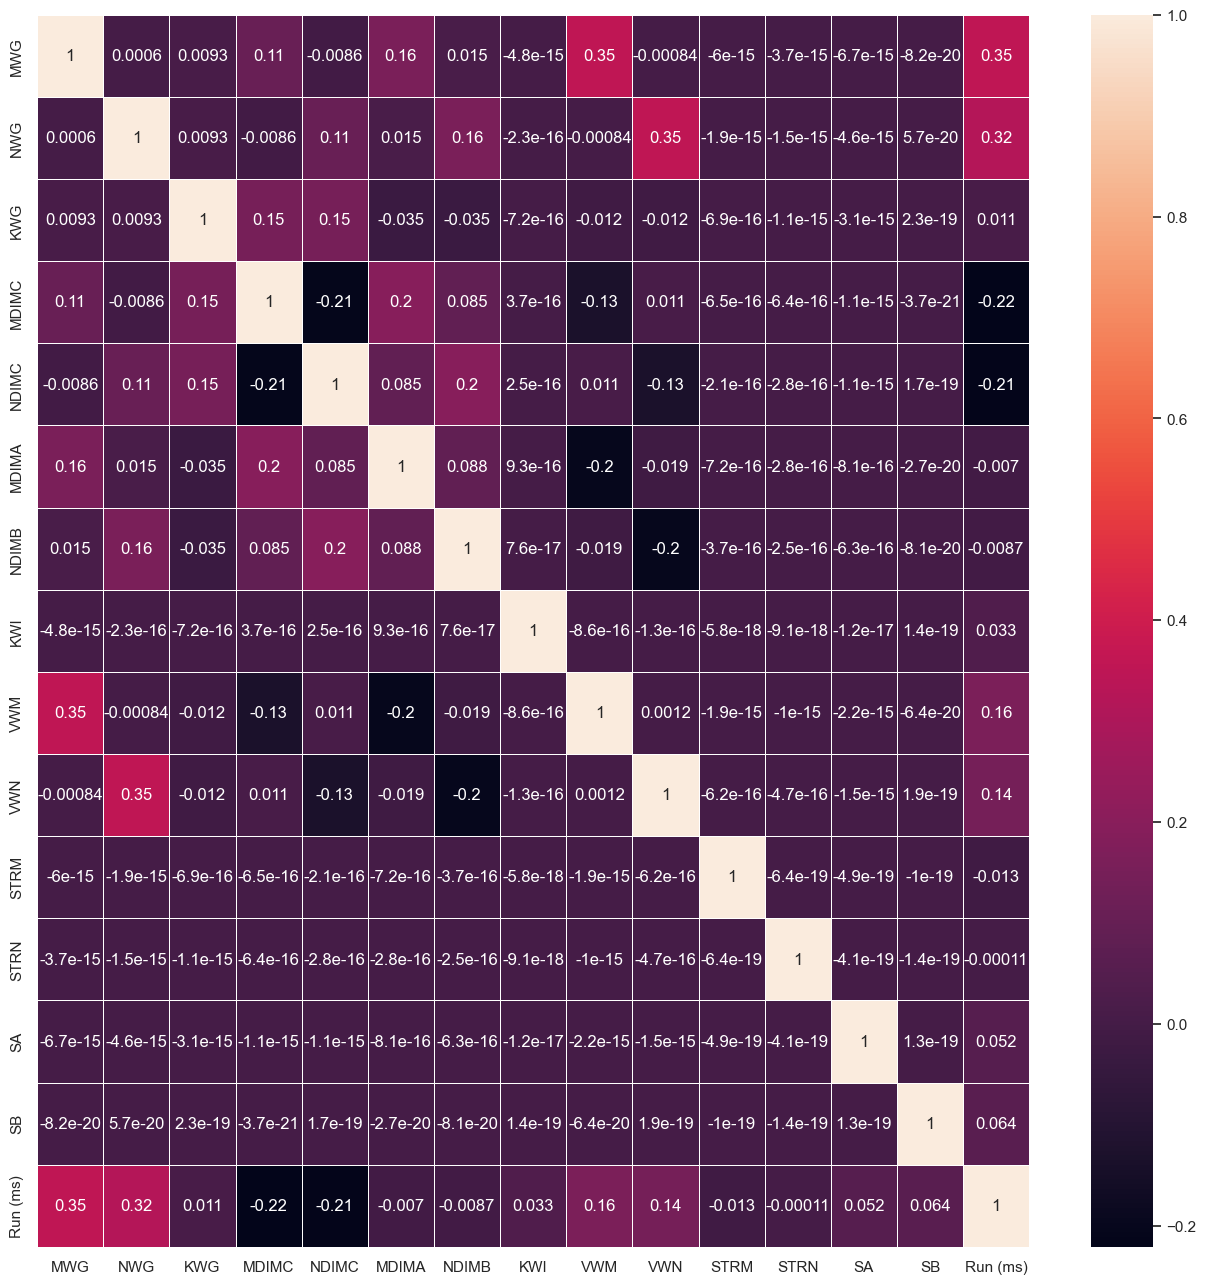

In [9]:
# Mirem la correlació entre els atributs d'entrada per entendre millor les dades
correlacio = dataset.corr()

plt.figure(figsize=(16,16))
sns.set(font_scale=1)

ax = sns.heatmap(correlacio, annot=True, linewidths=.5)

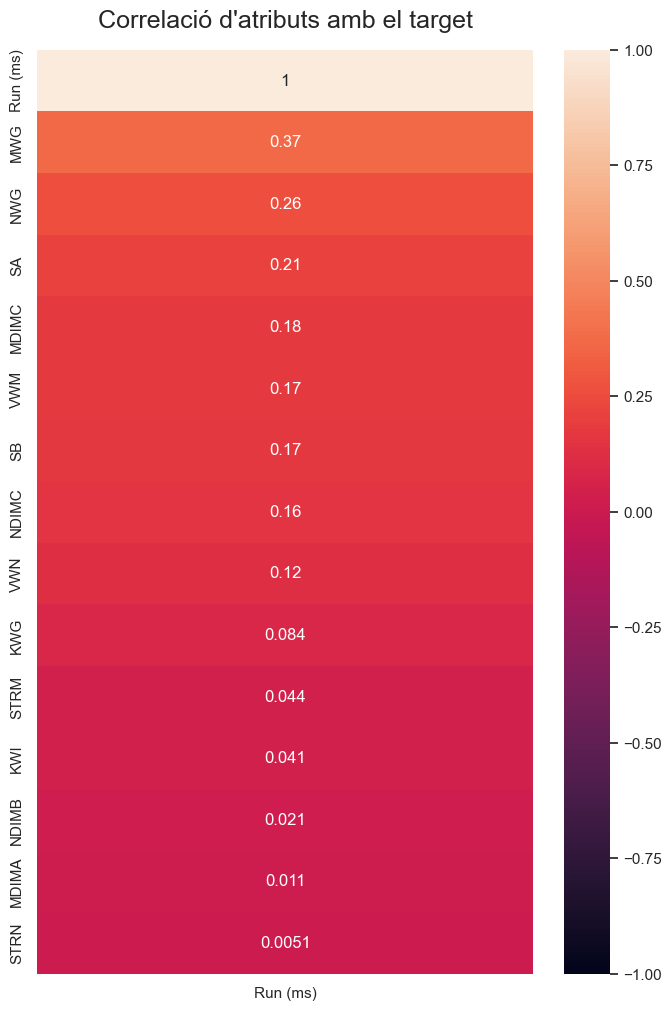

In [99]:
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(abs(dataset2.corr()[['Run (ms)']]).sort_values(by='Run (ms)', ascending=False), vmin=-1, vmax=1, annot=True)
heatmap.set_title("Correlació d'atributs amb el target", fontdict={'fontsize':18}, pad=16);

Com podem veure, els 4 atributs que més correlació tenen amb l'atribut objectiu son MWG, NWG, SA, VWN en aquest ordre, encara que totes les correlacions de les nostres dades son bastant baixes (cap atribut supera una correlació de 0.5). 

Provarem a entrenar els nostres models amb aquests 4 atributs ja que escollir massa atributs produirà overfitting en els models i d'aquesta manera assegurarem una bona generalització.


Agafarem aquests 4 atributs i el atribut target per la regressió.

In [100]:
reduced_dataset = dataset2[['MWG','NWG','SA','VWN','Run (ms)']]
reduced_dataset.describe()

,MWG,NWG,SA,VWN,Run (ms)
count,214833.000000,214833.000000,214833.000000,214833.000000,214833.000000
mean,75.688037,75.761619,0.486038,2.345156,114.554350
std,41.968313,41.997377,0.499806,1.862122,113.825481
min,16.000000,16.000000,0.000000,1.000000,13.317500
25%,32.000000,32.000000,0.000000,1.000000,39.095000
50%,64.000000,64.000000,0.000000,2.000000,61.790000
75%,128.000000,128.000000,1.000000,4.000000,157.892500
max,128.000000,128.000000,1.000000,8.000000,509.962500


Com podem observar a la fila **mean**, els valors entre els parells d'atributs MWG, NWG - VWM, VWN son bastant distants. Podem veure això també en un histograma:

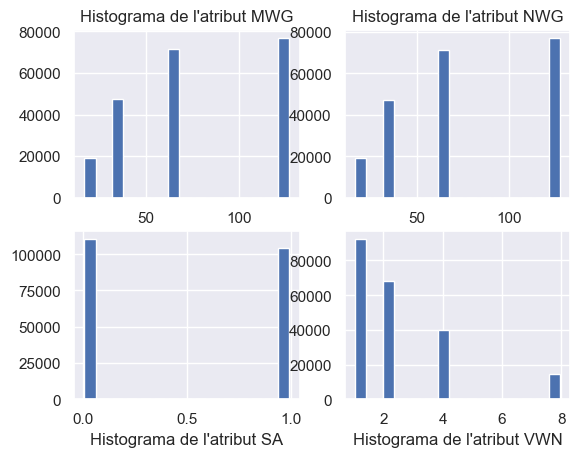

In [40]:
data = reduced_dataset.values
atributs = ['MWG', 'NWG', 'SA', 'VWN']
for i in range(0,4):
    ax = plt.subplot(2,2,i+1)
    if i > 1:
        plt.xlabel("Histograma de l'atribut " + atributs[i])
    else:
        plt.title("Histograma de l'atribut " + atributs[i])
        
    ax.hist(data[:,i], bins=15, range=[np.min(data[:,i]), np.max(data[:,i])], histtype="bar", rwidth=0.8)
    


Fem un escalat de les dades per solucionar aquesta diferència

In [42]:
d = dataset2.values[:] # All atributtes
d2 = reduced_dataset.values[:] # Most correlated parameters

#Scale all attributes 
scaler = StandardScaler()
scaler.fit(d)
data = scaler.transform(d)

#Scale most correlated attributes
scaler = StandardScaler()
scaler.fit(d2)
data2 = scaler.transform(d2)

x = data[:,:-1]
y = data[:, -1] 

x_filtered = data2[:,:-1]
y_filtered = data2[:,-1]

print(y)

[ 0.01595121 -0.31495086 -0.29861002 ... -0.69751108 -0.75643915
 -0.84987187]


Com podem veure ara tenim els 4 atributs que hem agafat en una mateixa escala.

# Selecció de Models

En aquest apartat probarem d'entrenar diferents tipus de models un cop ara tenim les dades escalades.

Considerarem els seguents regressors: **LinearRegression, Perceptron, SGDRegressor**

Primerament, dividim les dades en test i train:

In [90]:
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

[-0.79774438 -0.79774438 -0.79774438 ...  2.16111072  2.16111072
  2.16111072]


Creem els models:

In [53]:
linear_regression = LinearRegression()
decision_tree = DecisionTreeRegressor()
sgd = SGDRegressor()

I els entrenem amb les dades de train:

In [54]:
linear_regression.fit(x_train,y_train)
sgd.fit(x_train,y_train)
decision_tree.fit(x_train,y_train)

DecisionTreeRegressor()

### Linear Regression

Creem la predicció i comprovem el rendiment del model:

Rendiment del model (regressió linear): 0.4638430115010741
MSE: 0.5310893740909715


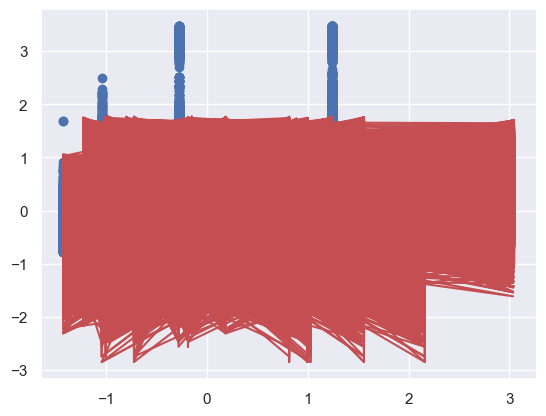

In [55]:
prediction = linear_regression.predict(x_test)
print("Rendiment del model (regressió linear): " + str(linear_regression.score(x_test, y_test)))
print("MSE: " + str(mean_squared_error(y_test, prediction)))

ax = plt.scatter(x_test[:,0], y_test)
plt.plot(x_test, prediction, 'r')

Com podem veure obtenim un score de 0.464 i un MSE de 0.52

### Decision Tree Regression

Creem la predicció i comprovem el rendiment del model:

Rendiment del model (decision tree): 0.9993596687354419
MSE: 0.0006342790223757288


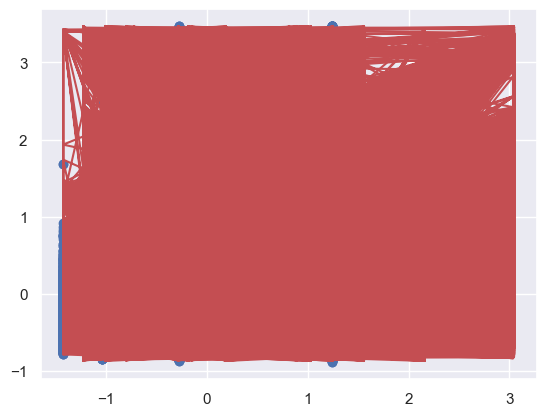

In [57]:
prediction = decision_tree.predict(x_test)
print("Rendiment del model (decision tree): " + str(decision_tree.score(x_test, y_test)))
print("MSE: " + str(mean_squared_error(y_test, prediction)))

ax = plt.scatter(x_test[:,0], y_test)
plt.plot(x_test, prediction, 'r')

En aquest cas obtenim un score de 0.286, millorant el del Linear Regression. En quant al MSE també aconseguim reduir-lo respecte al Linear Regression

### SGD Regressor

Creem la predicció i comprovem el rendiment del model: 

Rendiment del model (decision tree): 0.4630736821741509
MSE: 0.5318514319200588


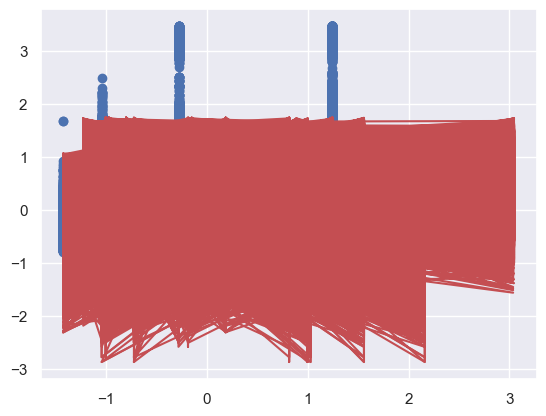

In [56]:
prediction = sgd.predict(x_test)
print("Rendiment del model (decision tree): " + str(sgd.score(x_test, y_test)))
print("MSE: " + str(mean_squared_error(y_test, prediction)))

ax = plt.scatter(x_test[:,0], y_test)
plt.plot(x_test, prediction, 'r')

Aquests entrenaments dels models estàn fets amb tots els paràmetres, per la qual cosa i com podem comprovar al Decision Tree Regressor, amb precisió de 0.999, estem produint **overfitting**.

Si fem una prova amb aquest mateix model, només agafant els 4 millors paràmetres, podem observar com el model disminueix la seva precisió:

Rendiment del model (decision tree): 0.33213210389981396
MSE: 0.6718673098006079


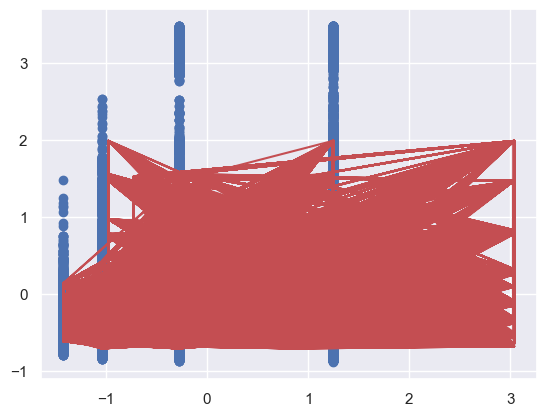

In [102]:
x_train, x_test, y_train, y_test = train_test_split(x_filtered, y_filtered, test_size=0.2)

testing_tree = DecisionTreeRegressor()
testing_tree.fit(x_train,y_train)

prediction = testing_tree.predict(x_test)
print("Rendiment del model (decision tree): " + str(testing_tree.score(x_test, y_test)))
print("MSE: " + str(mean_squared_error(y_test, prediction)))

ax = plt.scatter(x_test[:,0], y_test)
plt.plot(x_test, prediction, 'r')

Com podem veure hi ha una diferència gran entre utilitzar les 4 millors variables en quant a correlació i utilitzar totes. En el cas que utilitzem totes rebem millor rendiment als nostres models però això produeix overfitting per la qual cosa el model no generalitzarà bé. A continuació cercarem el nº òptim de variables a utilitzar.

# Cerca del nombre de variables òptima

In [67]:
variables = ['MWG','NWG', 'SA',  'VWM','MDIMC','SB', 'NDIMC','VWN', 'STRM','NDIMB' , 'KWI','MDIMA','KWG', 'STRN']

print(dataset2[variables[:2]])

        MWG  NWG
0        16   16
1        16   16
2        16   16
3        16   16
4        16   16
...     ...  ...
241595  128  128
241596  128  128
241597  128  128
241598  128  128
241599  128  128

[214833 rows x 2 columns]


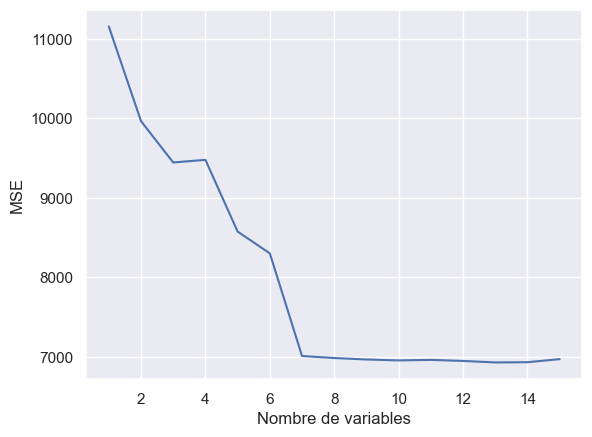

In [104]:
MSE_values = []

for i in range(1,16):
    X = dataset2[variables[:i]]
    X = X.to_numpy()
    Y = dataset2['Run (ms)'].to_numpy().ravel()
    X = scaler.fit_transform(X)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.25)

    regr = SGDRegressor(alpha = 0.0001)
    mse = cross_val_score(regr, X_train, Y_train, cv=5, scoring = "neg_mean_squared_error").mean()
    mse = abs(mse)
    MSE_values.append(mse)
    
plt.plot(range(1,16),MSE_values)
plt.xlabel('Nombre de variables')
plt.ylabel('MSE')
plt.show()

Com podem veure a la gràfica, el nombre de variables òptim son les primeres 7, on aconseguim reduir el MSE fins a un punt on ja no baixa, i d'aquesta manera evitarem de millor manera l'overfitting 

Rendiment del model (decision tree): 0.9367090654402194
MSE: 0.06312324654357267


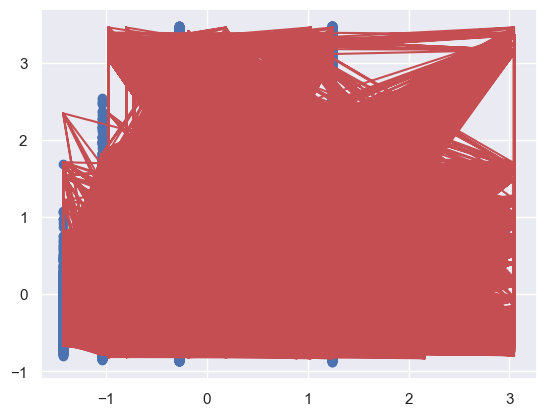

In [91]:
millors_variables = ['MWG','NWG', 'SA',  'VWM','MDIMC','SB', 'NDIMC','Run (ms)']

reduced_dataset = dataset2[millors_variables]
reduced_dataset.describe()

data = reduced_dataset.values
scaler = StandardScaler()
scaler.fit(data)
data = scaler.transform(data)

x = data[:,:-1]
y = data[:, -1] 


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
decision_tree = DecisionTreeRegressor()
decision_tree.fit(x_train,y_train)
prediction = decision_tree.predict(x_test)
print("Rendiment del model (decision tree): " + str(decision_tree.score(x_test, y_test)))
print("MSE: " + str(mean_squared_error(y_test, prediction)))

ax = plt.scatter(x_test[:,0], y_test)
plt.plot(x_test, prediction, 'r')

Com podem veure, en aquest cas només utilitzant 7 variables en comptes de 15 com en el cas on utilitzem totes les variables que tenim, amb el model Decision Tree Regressor obtenim una accuracy molt alta i un MSE baix, utilitzant moltes menys variables i evitant així de millor manera l'overfitting.

A continuació veurem el rendiment dels dos altres models, **SGD Regressor i  Linear Regression** amb aquest mateix nombre de variables per veure aquesta millora en quant al rendiment

### SGD Regressor

Rendiment del model (decision tree): 0.45710441364333454
MSE: 0.5414571957796035


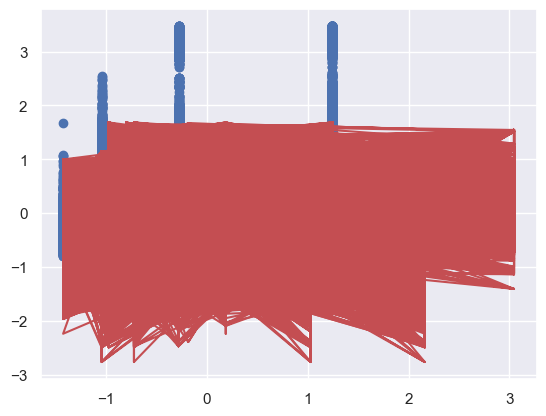

In [97]:
sgd = SGDRegressor().fit(x_train,y_train)

prediction = sgd.predict(x_test)
print("Rendiment del model (decision tree): " + str(sgd.score(x_test, y_test)))
print("MSE: " + str(mean_squared_error(y_test, prediction)))

ax = plt.scatter(x_test[:,0], y_test)
plt.plot(x_test, prediction, 'r')

### Linear Regression

Rendiment del model (regressió linear): 0.45777856831261643
MSE: 0.5407848272691119


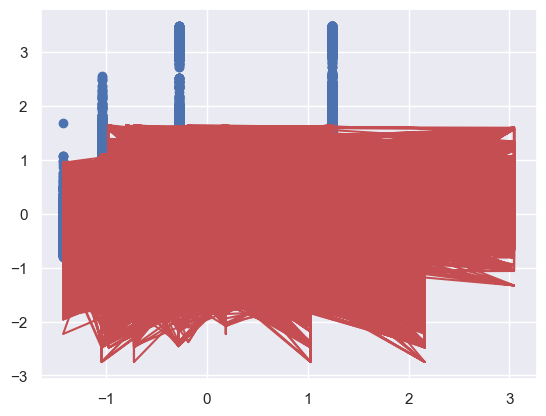

In [98]:
linear_regression = LinearRegression().fit(x_train,y_train)

prediction = linear_regression.predict(x_test)
print("Rendiment del model (regressió linear): " + str(linear_regression.score(x_test, y_test)))
print("MSE: " + str(mean_squared_error(y_test, prediction)))

ax = plt.scatter(x_test[:,0], y_test)
plt.plot(x_test, prediction, 'r')



# Cerca d'hiperparàmetres

A continuació farem una cerca dels millors hiperparàmetres per a l'exemple anterior amb el model que millor funciona per al nostre problema, el **Decision Tree Regressor**

Escollim un conjunt de valors diferents que es troben disponibles per al nostre model:

In [93]:
param_decisiontree = {"splitter":["best","random"],
            "max_depth" : [1,3,5,10,15,25,30,50],
            "min_weight_fraction_leaf":[0.0,0.1,0.2,0.3,0.4,0.5],
           "max_features":["auto","log2","sqrt",None],
           "max_leaf_nodes":[None,10,20,50,80,100,250,500] }

### Decision Tree Regression

In [94]:
grid_decisiontree = GridSearchCV(DecisionTreeRegressor(), param_decisiontree, cv=3, verbose=2, n_jobs=-1)
grid_decisiontree.fit(x_train,y_train)
print("Els millors parametres: " + str(grid_decisiontree.best_params_))
print("La millor score: " + str(grid_decisiontree.best_score_))
print("Error quadratic mitja: " + str(math.sqrt(mean_squared_error(y_test,grid_decisiontree.predict(x_test)))))

Fitting 3 folds for each of 3072 candidates, totalling 9216 fits
Els millors parametres: {'max_depth': 15, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_weight_fraction_leaf': 0.0, 'splitter': 'best'}
La millor score: 0.9370139885690283
Error quadratic mitja: 0.2512434009950762


Com podem veure, els hiperparàmetres no son la causa de l'score obtingut al model, ja que obtenim un score similar o una mica millor però el MSE està incrementant bastant.

Per la qual cosa, suposem que els millors paràmetres son els que el model està utilitzant per defecte